## Installing and Importing Packages, and Mounting Google Drive

In [1]:
# useful installations
!pip install sacremoses

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import sys
import math

import string
from collections import defaultdict

from google.colab import data_table

from sacremoses import MosesPunctNormalizer

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

This involves reading the data from text files into lists, and converting the lists into a `pandas.DataFrame` for further processing.

When reading text files, we ensure that characters in the files are encoded as `utf-8` characters.

In [4]:
# define source and target languages
source_name = 'English'
target_name = 'Northern Sesotho'

source_code = 'eng'
target_code = 'nso'

In [5]:
# loading data
main_path = f'/content/drive/My Drive/Research/{source_code}-to-{target_code}'
source_path = f'{main_path}/{source_code}.txt'
target_path = f'{main_path}/{target_code}.txt'

with open(source_path, 'r', encoding='utf-8') as f:
  source = f.read().splitlines()

with open(target_path, 'r', encoding='utf-8') as f:
  target = f.read().splitlines()

In [6]:
# convert text files containing source and target segments to pandas.DataFrame
df = pd.DataFrame({source_name:source, target_name:target})
N = len(df)
print(f"The number of segment pairs in the parallel corpus BEFORE any preprocessing: {N}.")

The number of segment pairs in the parallel corpus BEFORE any preprocessing: 44980.


In [7]:
# visualise dataframe
data_table.DataTable(df, include_index=True, num_rows_per_page=20)

Output hidden; open in https://colab.research.google.com to view.

## Data Splitting

This involves splitting the parallel corpus into training/validation/testing corpora.

We have access to a global test corpus, we need to filter out any copies of the source segments in the global test corpus from the training and validation corpora.

### Splitting data into train/validation/test sets:

In [8]:
# shuffling segment pairs in the parallel corpus
seed = 2024
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# splitting parallel corpus
df_test = df.sample(n=3000, random_state=seed)
df_train = df.drop(df_test.index, axis=0, inplace=False)
df_val = df_train.sample(frac=0.2, random_state=seed)
df_train.drop(df_val.index, axis=0, inplace=True)

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f"Number of segment pairs in training set: {len(df_train)}")
print(f"Number of segment pairs in validation set: {len(df_val)}")
print(f"Number of segment pairs in test set: {len(df_test)}")

Number of segment pairs in training set: 33584
Number of segment pairs in validation set: 8396
Number of segment pairs in test set: 3000


### Filtering out segment pairs from test set and global test set:

In [9]:
# filtering segment pairs from training set using test corpus
index = df_train[df_train[source_name].isin(df_test)].index
if len(index) > 0:
  df_train.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segment pairs left in the training corpus: {len(df_train)} \n")

# filtering segment pairs from validation set using test corpus
index = df_val[df_val[source_name].isin(df_test)].index
if len(index) > 0:
  df_val.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segments pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

The number of segment pairs left in the training corpus: 33584 

The number of segments pairs left in the validation corpus: 8396


In [10]:
gtest_path = f'{main_path}/Autshumato-Evaluation-Set/Autshumato.EvaluationSet.English.Translator1.txt'
with open(gtest_path, 'r', encoding='utf-8') as f:
  gtest = f.read().splitlines()

# filtering segment pairs from training set using global test corpus 1
index = df_train[df_train[source_name].isin(gtest)].index
if len(index) > 0:
  df_train.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segment pairs left in the training corpus: {len(df_train)} \n")

# filtering segment pairs from validation set using global test corpus 1
index = df_val[df_val[source_name].isin(gtest)].index
if len(index) > 0:
  df_val.drop(index, axis=0, inplace=True)
  print(f"Segments are being removed from the corpus...")
print(f"The number of segments pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

The number of segment pairs left in the training corpus: 33584 

The number of segments pairs left in the validation corpus: 8396


## Text Normalization

This involves improving the consistency of text within a language, and between source and target segments in a segment pair.

The following steps for text normalization are deployed in training and validation corpora.

### Checking for invalid `utf-8` characters:

In [11]:
# function to check for invalid utf-8 characters in a segment
def check_invalid_utf8(segment):
  """
  This function checks if a segment contains invalid UTF-8 characters.

  Args:
    segment (str): The segment to be processed.

  Return:
    True if the segment contains an invalid UTF-8 character, False otherwise.
  """

  try:
    segment.encode('utf-8').decode('utf-8')
    return False
  except UnicodeDecodeError:
    return True

In [12]:
# are there any invalid utf-8 characters in the training corpus?
invalid_utf8_source = []
invalid_utf8_target = []

for i in range(len(df_train)):
  if check_invalid_utf8(df_train.iloc[i,0]) == True:
    invalid_utf8_source.append(i)

  if check_invalid_utf8(df_train.iloc[i,1]) == True:
    invalid_utf8_target.append(i)

print("Training Corpus:")
print(f"The number of segments on the {source_name} side with invalid UTF-8 characters: {len(invalid_utf8_source)}.")
print(f"The number of segments on the {target_name} side with invalid UTF-8 characters: {len(invalid_utf8_target)}.")

# are there any invalid utf-8 characters in the validation corpus?
invalid_utf8_source = []
invalid_utf8_target = []

for i in range(len(df_val)):
  if check_invalid_utf8(df_val.iloc[i,0]) == True:
    invalid_utf8_source.append(i)

  if check_invalid_utf8(df_val.iloc[i,1]) == True:
    invalid_utf8_target.append(i)

print("\nValidation Corpus:")
print(f"The number of segments on the {source_name} side with invalid UTF-8 characters: {len(invalid_utf8_source)}.")
print(f"The number of segments on the {target_name} side with invalid UTF-8 characters: {len(invalid_utf8_target)}.")

Training Corpus:
The number of segments on the English side with invalid UTF-8 characters: 0.
The number of segments on the Northern Sesotho side with invalid UTF-8 characters: 0.

Validation Corpus:
The number of segments on the English side with invalid UTF-8 characters: 0.
The number of segments on the Northern Sesotho side with invalid UTF-8 characters: 0.


### Removing non-printable characters:

In [13]:
# are there any non-printable characters in the training corpus?
non_print_source = []
non_print_target = []

for i in range(len(df_train)):
  if df_train.iloc[i,0].isprintable() == False:
    non_print_source.append(i)

  if df_train.iloc[i,1].isprintable() == False:
    non_print_target.append(i)

print("Training Corpus:")
print(f"The number of segments on the {source_name} side with non-printable characters: {len(non_print_source)}.")
print(f"The number of segments on the {target_name} side with non-printable characters: {len(non_print_target)}.")

Training Corpus:
The number of segments on the English side with non-printable characters: 744.
The number of segments on the Northern Sesotho side with non-printable characters: 493.


In [14]:
# visualise source segments with non-printable characters
df_train.iloc[non_print_source, 0].tolist()

['The suspect Nyandeni grabbed\xa0Samkelisiwe,\xa0lifted her up and dropped her on the bed, assaulting her.',
 '\ufeffany other information that the Registrar may request ',
 '\ufeffThis option is available on a project basis to beneficiaries , via consolidation , institutional and project-linked subsidies .',
 'They\xa0further charged the suspects\xa0for bribing a police officer when they\xa0offered the police members money\xa0in Bramley Crescent Street in Germiston.',
 'A little while later, the robbers were\xa0spotted in a white Toyota Conquest.',
 'They\xa0were on patrol when\xa0they spotted a suspicious red Volkswagen bakkie heading towards Bethlehem from Fouriesburg.',
 '\ufeffCost ',
 'Mitchells Plain Police, headed by Director Jeremy Vearey, worked tirelessly to arrest eight suspects for\xa0taxi violence.',
 '\ufeffTop ',
 '\ufeffApplications can be made at any Home Affairs office or at a South African embassy or mission if you apply abroad. ',
 'Crime prevention patrols and a 

In [15]:
# visualise target segments with non-printable characters
df_train.iloc[non_print_target, 1].tolist()

['Mgononelwa Nyandeni o swere\xa0Samkelisiwe,\xa0a mo iša godimo gomme a mo lahlela mpeteng, gomme a mmetha.',
 '\ufefftshedimošo efe goba efe yeo Mongwadiši a ka e kgopelago ',
 '\ufeffKgetho ye e hwetšagala go motheo wa projeke go baputseletšwa , ka teefatšo , instithušene le diabelo tšeo di amantšwego le diprojeke . ',
 '\ufeffTefelo ',
 '\ufeffGodimo ',
 '\ufeffDikgopelo di ka dirwa kantorong efe goba efe ya Merero ya Selegae goba kantorong ya botseta goba mišeneng wa Afrika Borwa ge o dira kgopelo ka ntle ga naga. ',
 '\ufeffApplication for settlement on state land ',
 '\ufeffTsela e latelwago ',
 'Ka morago ga go sebotša ke setšhaba, maloko a Matseka a  Alldays ka fase ga Insp.\xa0Mathebula a ile a golega lehodu.',
 '\ufeffMolao o šomišwago ',
 '\ufeffGodimo ',
 '\ufeffThe Commissioner: SARS ',
 '\ufeffGa go na kalafi ya Aids ',
 '\ufeffLenaneotlhahlo ke mokgwa wo mongwe wa tlhahlo wo o nepiša kudu go fa motho maitemogelo a mošomo . ',
 '\ufeffTlatša foromo ya kgopelo ya BI-1738.

In [16]:
# function to remove non-printable characters from the segment
def remove_non_printable_chars(segment):
  """
  This function removes non-printable characters from a segment.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment without non-printable characters.
  """

  return "".join([char for char in segment if char.isprintable()])

In [17]:
# remove non-printable characters from the training corpus
for i in non_print_source:
  df_train.iloc[i,0] = remove_non_printable_chars(df_train.iloc[i,0])

for i in non_print_target:
  df_train.iloc[i,1] = remove_non_printable_chars(df_train.iloc[i,1])


In [18]:
# are there any non-printable characters in the validation corpus?
non_print_source = []
non_print_target = []

for i in range(len(df_val)):
  if df_val.iloc[i,0].isprintable() == False:
    non_print_source.append(i)

  if df_val.iloc[i,1].isprintable() == False:
    non_print_target.append(i)

print("\nValidation Corpus:")
print(f"The number of segments on the {source_name} side with non-printable characters: {len(non_print_source)}.")
print(f"The number of segments on the {target_name} side with non-printable characters: {len(non_print_target)}.")


Validation Corpus:
The number of segments on the English side with non-printable characters: 184.
The number of segments on the Northern Sesotho side with non-printable characters: 128.


In [19]:
# visualise source segments with non-printable characters
df_val.iloc[non_print_source, 0].tolist()

['\ufeffThe MEC ( Member of Executive Council ) of Transport of the province in which the application is made will send the inspectorate to evaluate the facilities and recommend the appropriate grading of the driving licence testing centre .',
 'The police in Malmesbury arrested\xa0six men\xa0in connection with an incident at a house in Malmesbury.',
 '\ufeffPayment can be made electronically or over the counter , but it is essential that the invoice number be recited in order to reconcile payment with the issued invoice .',
 'Two Ford sedans were confiscated and the arrested suspect is due to appear\xa0in court soon.',
 'The purpose of the operation was to combat serious violent economical crimes, motor vehicle thefts, cash heists,\xa0armed robbery and to enforce rural safety.',
 'A Dog Master and the dog must be properly trained in order to professionally handle this type of\xa0evidence.',
 'Members\xa0of the Metro Police and Johannesburg SAPS cornered the suspects in Yeoville.',
 "O

In [20]:
# visualise target segments with non-printable characters
df_val.iloc[non_print_target, 1].tolist()

['\ufeffMolekgotlaphethiši wa Kgoro ya Dinamelwa profenseng yeo kgopelo e dirwago go yona o tlo romela balekodi gore ba lekole lefelo leo le ditlabelwa tša lona le go dira tigelo ya mabapi le go dumelelwa ga lefelo leo . ',
 '\ufeffTefelo e ka dirwa ka mokgwa wa seelektroniki goba khaonthareng , eupša go bohlokwa gore nomoro ya lenanetheko e gopolwe gore o tle o kgone go bapetša tefelo le lenanetheko leo le filwego . ',
 'Mafelo ao go šomelwago go ona ke Dirapa tša thoko ya Lewatleng,\xa0Vissershoek\xa0le\xa0Bellville South\xa0gomme mafelo a a sekasekwa go tlo dirwa lefelo le lefsa gore re kgone ka kgolo ya toropokgolo.',
 '\ufeffMolao o šomišwago ',
 '\ufeffTirelo ga e lefelwe . ',
 '\ufeffGodimo ',
 '\ufeffTlhahlo ya Khomišene ya Afrika Borwa ya Ditokelo tša Botho ka ga tšhomišo ya Molao 6 ',
 '\ufeffTsela e latelwago ',
 '\ufeffTsela e latelwago ',
 '\ufeffTšhelete ya letseno go tšwa go dipeeletšo, ditokelo tša thoto le mašokotšo ',
 '\ufeffIkgokaganye le lefelo la thekgo ya batšwas

In [21]:
# remove non-printable characters from the validation corpus
for i in non_print_source:
  df_val.iloc[i,0] = remove_non_printable_chars(df_val.iloc[i,0])

for i in non_print_target:
  df_val.iloc[i,1] = remove_non_printable_chars(df_val.iloc[i,1])

### Normalising punctuation use:


In [22]:
# replace dash with hyphen
for i in range(len(df_train)):
  df_train.iloc[i,0] = df_train.iloc[i,0].replace("―", "-")
  df_train.iloc[i,1] = df_train.iloc[i,1].replace("―", "-")

for i in range(len(df_val)):
  df_val.iloc[i,0] = df_val.iloc[i,0].replace("―", "-")
  df_val.iloc[i,1] = df_val.iloc[i,1].replace("―", "-")

In [23]:
# a function that does the following: if a hyphen is being used as a dash,
# then there should be a space BEFORE and AFTER the hyphen.
def hyphen_as_dash(segment):
  """
  This function determines whether a hyphen is being used as a dash. If yes,
  then it ensures that there is a whitespace before and after the hyphen.

  Args:
    segment (str): segment to be processed.

  Returns:
    The segment with hyphens as dashes with whitespace before and after the hyphen.
  """
  segment = " " + segment + " "
  indices = [index for (index, token) in enumerate(segment) if token == "-"]
  for i in indices:
    if segment[i+1] == " ":
      segment = segment[:i] + " -" + segment[i+1:]
  return segment[1:-1]

In [24]:
# ensure that there is a whitespace before and after hyphens that are being used as dashes.
# any extra whitespace will be removed by `MosesPunctNormalizer()`
for i in range(len(df_train)):
  if "-" in df_train.iloc[i,0]:
    df_train.iloc[i,0] = hyphen_as_dash(df_train.iloc[i,0])
  if "-" in df_train.iloc[i,1]:
    df_train.iloc[i,1] = hyphen_as_dash(df_train.iloc[i,1])

for i in range(len(df_val)):
  if "-" in df_val.iloc[i,0]:
    df_val.iloc[i,0] = hyphen_as_dash(df_val.iloc[i,0])
  if "-" in df_val.iloc[i,1]:
    df_val.iloc[i,1] = hyphen_as_dash(df_val.iloc[i,1])

In [25]:
# creating an instance of the sacremoses punctuation normalizer class
moses_punct_norm = MosesPunctNormalizer(
    lang="en",
    penn=True,                      # Normalize Penn Treebank style quotations.
    norm_quote_commas=True,         # Normalize quotations and commas
    norm_numbers=True,              # Normalize numbers
    pre_replace_unicode_punct=True, # Replace all punctuation with unicode punctuation
    post_remove_control_chars=True) # Remove all control characters

In [26]:
# normalising punctuation in training corpus
for i in range(len(df_train)):
  df_train.iloc[i,0] = moses_punct_norm.normalize(df_train.iloc[i,0])
  df_train.iloc[i,1] = moses_punct_norm.normalize(df_train.iloc[i,1])

# normalising punctuation in validation corpus
for i in range(len(df_val)):
  df_val.iloc[i,0] = moses_punct_norm.normalize(df_val.iloc[i,0])
  df_val.iloc[i,1] = moses_punct_norm.normalize(df_val.iloc[i,1])

### Normalising letter casing:

In [27]:
# which segments have words in all caps in the training corpus?
source_caps = []
target_caps = []

for i in range(len(df_train)):
  for s_word in df_train.iloc[i,0].split():
    if len(s_word) > 1 and s_word.isupper() == True:
      source_caps.append(i)

  for t_word in df_train.iloc[i,1].split():
    if len(t_word) > 1 and t_word.isupper() == True:
      target_caps.append(i)

source_caps = list(set(source_caps))
target_caps = list(set(target_caps))

In [28]:
# visualise source side
data_table.DataTable(df_train.iloc[source_caps], include_index=True, num_rows_per_page=20)

,English,Northern Sesotho
32768,Complete the application form: IE 462,Tlatša foromo ya kgopelo: IE 462.
24580,Generic estuarine management plane completed a...,Taolo ya dinoka mabopong a lewatle e feditšwe ...
8198,"Application for permanent residence permit, BI...","Application for permanent residence permit, BI..."
16390,As part of the SCMP for each area a record wil...,Bjalo ka karolo ya SCMP lefelo le lengwe le le...
32777,where lacking within a period to be determined...,mo bo sego gona/hlokegago mo sebakeng seo se t...
...,...,...
24561,Full or limited commercial fishing rights are ...,Ditokelo ka botlalo goba tše di sa felelago tš...
32760,must submit an application for registration to...,o swanetše go tlatša foromo ofising ya kgauswi...
32761,"An amount of R, being the application fee spec...",Seboka SA R e lego tšhelete ya kgopelo ye e šu...
24570,CPIX is used by the SA Reserve Bank as the mea...,CPIX e dirišwa ke Panka ya Resefe ya Afrika Bo...


In [29]:
# visualise target side
data_table.DataTable(df_train.iloc[target_caps], include_index=True, num_rows_per_page=20)

,English,Northern Sesotho
32768,Complete the application form: IE 462,Tlatša foromo ya kgopelo: IE 462.
24579,The formalisation of diplomatic relations gave...,Lefapha la Taolo ya WCED: Peakanyo e hlophile ...
24580,Generic estuarine management plane completed a...,Taolo ya dinoka mabopong a lewatle e feditšwe ...
8198,"Application for permanent residence permit, BI...","Application for permanent residence permit, BI..."
16390,As part of the SCMP for each area a record wil...,Bjalo ka karolo ya SCMP lefelo le lengwe le le...
...,...,...
24563,MFDAfrica's Shred Shed division provides a con...,Karolo ya MFD Africa's Shred Shed e fana ka ti...
32760,must submit an application for registration to...,o swanetše go tlatša foromo ofising ya kgauswi...
32761,"An amount of R, being the application fee spec...",Seboka SA R e lego tšhelete ya kgopelo ye e šu...
24570,CPIX is used by the SA Reserve Bank as the mea...,CPIX e dirišwa ke Panka ya Resefe ya Afrika Bo...


In [30]:
# if all upper caps on source side, then source and target sides must be all lower caps, and
# if all upper caps on target side, then source and target sides must be all lower caps.
caps = list(set(source_caps + target_caps))

for i in caps:
  if df_train.iloc[i,0].isupper() == True:
    df_train.iloc[i,0] = df_train.iloc[i,0].lower()
    df_train.iloc[i,1] = df_train.iloc[i,1].lower()

  if df_train.iloc[i,1].isupper() == True:
    df_train.iloc[i,0] = df_train.iloc[i,0].lower()
    df_train.iloc[i,1] = df_train.iloc[i,1].lower()

In [31]:
# visualise dataframe
data_table.DataTable(df_train.iloc[caps], include_index=True, num_rows_per_page=20)

,English,Northern Sesotho
32768,Complete the application form: IE 462,Tlatša foromo ya kgopelo: IE 462.
24579,The formalisation of diplomatic relations gave...,Lefapha la Taolo ya WCED: Peakanyo e hlophile ...
24580,Generic estuarine management plane completed a...,Taolo ya dinoka mabopong a lewatle e feditšwe ...
8198,"Application for permanent residence permit, BI...","Application for permanent residence permit, BI..."
16390,As part of the SCMP for each area a record wil...,Bjalo ka karolo ya SCMP lefelo le lengwe le le...
...,...,...
24563,MFDAfrica's Shred Shed division provides a con...,Karolo ya MFD Africa's Shred Shed e fana ka ti...
32760,must submit an application for registration to...,o swanetše go tlatša foromo ofising ya kgauswi...
32761,"An amount of R, being the application fee spec...",Seboka SA R e lego tšhelete ya kgopelo ye e šu...
24570,CPIX is used by the SA Reserve Bank as the mea...,CPIX e dirišwa ke Panka ya Resefe ya Afrika Bo...


In [32]:
# which segments have words in all caps in the validation corpus?
source_caps = []
target_caps = []

for i in range(len(df_val)):
  for s_word in df_val.iloc[i,0].split():
    if len(s_word) > 1 and s_word.isupper() == True:
      source_caps.append(i)

  for t_word in df_val.iloc[i,1].split():
    if len(t_word) > 1 and t_word.isupper() == True:
      target_caps.append(i)

source_caps = list(set(source_caps))
target_caps = list(set(target_caps))

In [33]:
# if all upper caps on source side, then source and target sides must be all lower caps, and
# if all upper caps on target side, then source and target sides must be all lower caps.
caps = list(set(source_caps + target_caps))

for i in caps:
  if df_val.iloc[i,0].isupper() == True:
    df_val.iloc[i,0] = df_val.iloc[i,0].lower()
    df_val.iloc[i,1] = df_val.iloc[i,1].lower()

  if df_val.iloc[i,1].isupper() == True:
    df_val.iloc[i,0] = df_val.iloc[i,0].lower()
    df_val.iloc[i,1] = df_val.iloc[i,1].lower()

### Ensuring that there is a space between words and punctuation marks:



In [34]:
# function to ensure that there is a whitespace before and after punctuation marks
punc = string.punctuation.replace("-", "") # we exclude hyphen because it has already been dealt with
punc = punc.replace("'", "")

# add whitespace before punctuation mark
def add_whitespace_before_punct(segment):
  """
  This function ensures that there is a whitespace before each punctuation mark.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment with whitespace before punctuation marks.

  """
  punc_positions = []
  for i, symbol in enumerate(segment):
    if symbol in punc:
      punc_positions.append(i)

  for i in range(len(punc_positions)):
    if segment[punc_positions[i]-1] != " ":
      segment = segment[0:punc_positions[i]] + " " + segment[punc_positions[i]:]
      punc_positions[i+1: ] = [pos+1 for pos in punc_positions[i+1: ]]

  return segment

# add whitespace after punctuation mark
def add_whitespace_after_punct(segment):
  """
  This function ensures that there is a whitespace after each punctuation mark,
  excluding punctuation mark at the end of a segment.

  Args:
    segment (str): The segment to be processed.

  Returns:
    The segment with whitespace after punctuation marks.

  """
  punc_positions = []
  for i, symbol in enumerate(segment):
    if symbol in punc:
      punc_positions.append(i)

  if punc_positions != []:
    if punc_positions[-1] == len(segment)-1:
      punc_positions = punc_positions[:-1]

    for i in range(len(punc_positions)):
      if segment[punc_positions[i]+1] != " ":
        segment = segment[0:punc_positions[i]+1] + " " + segment[punc_positions[i]+1:]
        punc_positions[i+1: ] = [pos+1 for pos in punc_positions[i+1: ]]

  return segment

In [35]:
# adding whitespaces before and after punctuation marks for the entire training corpus
for i in range(len(df_train)):
  df_train.iloc[i,0] = add_whitespace_after_punct(add_whitespace_before_punct(df_train.iloc[i,0])).strip()
  df_train.iloc[i,1] = add_whitespace_after_punct(add_whitespace_before_punct(df_train.iloc[i,1])).strip()

# adding whitespaces before and after punctuation marks for the entire validation corpus
for i in range(len(df_val)):
  df_val.iloc[i,0] = add_whitespace_after_punct(add_whitespace_before_punct(df_val.iloc[i,0])).strip()
  df_val.iloc[i,1] = add_whitespace_after_punct(add_whitespace_before_punct(df_val.iloc[i,1])).strip()

In [36]:
# visualising dataframe
data_table.DataTable(df_train.head(10), include_index=True, num_rows_per_page=10)

,English,Northern Sesotho
0,The cashbox activated and gave off a slight bl...,Mapokisi a tšhelete a ile a dirwa gore a thome...
1,Legal framework,Molao o šomišwago
2,Steps to follow,Tsela e latelwago
3,In non-pregnant cows the organism is found in ...,"Go dikgomo tše di sa imago , sephedi se humanw..."
4,Some of the pieces have incredible detail and ...,Tše dingwe tša dikarolo di nale dinthla tše di...
5,To reform and harmonise petroleum regulations ...,"Mo Sontageng se se fetilego , maphodiSa a nyak..."
6,Description,Tlhalošo
7,or in fulfilment of an international obligation .,"Ke Mopresidente fela , bjalo ka hlogo ya khudu..."
8,You presumably had a plastic bottle ?,O be o akanya gore o na le lebotlelo la polast...
9,"For example , slapping , hitting , pushing , r...","Mohlala , go betha , go kgorometša , go swara ..."


## Filtering out Segment Pairs

This involves filtering out segment pairs that are potentially misaligned.

### Removing empty lines:



In [37]:
# removing empty lines in training corpus
empty_lines = []
for i in range(len(df_train)):
  if df_train.iloc[i,0] == '' or df_train.iloc[i,1] == '':
    empty_lines.append(i)

df_train.drop(empty_lines, axis=0, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

# removing empty lines in validation corpus
empty_lines = []
for i in range(len(df_val)):
  if df_val.iloc[i,0] == '' or df_val.iloc[i,1] == '':
    empty_lines.append(i)

df_val.drop(empty_lines, axis=0, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 33581
The number of segment pairs left in validation corpus: 8396


In [38]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Removing duplicates:

In [39]:
# remove duplicate source-target pairs
df_train.drop_duplicates(inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 23359
The number of segment pairs left in validation corpus: 6696


In [40]:
# remove segments that are identical on the source and target side
identical_pairs = df_train[df_train[source_name] == df_train[target_name]].index
df_train.drop(identical_pairs, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

identical_pairs = df_val[df_val[source_name] == df_val[target_name]].index
df_val.drop(identical_pairs, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 23272
The number of segment pairs left in validation corpus: 6661


In [41]:
# remove repeating segment pairs where the same source segment is aligned with multiple different target segments
df_train.drop_duplicates(subset=source_name, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(subset=source_name, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 21763
The number of segment pairs left in validation corpus: 6478


In [42]:
# remove repeating segment pairs where the same target segment is aligned with multiple different source segments
df_train.drop_duplicates(subset=target_name, inplace=True)
print(f"The number of segment pairs left in training corpus: {len(df_train)}")

df_val.drop_duplicates(subset=target_name, inplace=True)
print(f"The number of segment pairs left in validation corpus: {len(df_val)}")

The number of segment pairs left in training corpus: 21271
The number of segment pairs left in validation corpus: 6408


In [43]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Removing outlier segment pairs w.r.t length of segment:

In [44]:
# create a new dataframe: length of sentences on each side of the training corpus
df_train_sent_len = pd.DataFrame({source_name: df_train[source_name].str.split().apply(len), target_name:df_train[target_name].str.split().apply(len)})
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

# create a new dataframe: length of sentences on each side of the validation corpus
df_val_sent_len = pd.DataFrame({source_name: df_val[source_name].str.split().apply(len), target_name:df_val[target_name].str.split().apply(len)})
print("\nSummary for Validation Corpus:")
print(df_val_sent_len.describe())

Summary for Training Corpus:
            English  Northern Sesotho
count  21271.000000      21271.000000
mean      18.652014         23.477740
std        9.368771         11.817917
min        1.000000          1.000000
25%       13.000000         16.000000
50%       18.000000         22.000000
75%       23.000000         30.000000
max      221.000000        258.000000

Summary for Validation Corpus:
           English  Northern Sesotho
count  6408.000000       6408.000000
mean     18.133739         22.837547
std       9.028201         11.544743
min       1.000000          1.000000
25%      12.000000         15.000000
50%      17.000000         22.000000
75%      23.000000         29.000000
max     108.000000        111.000000


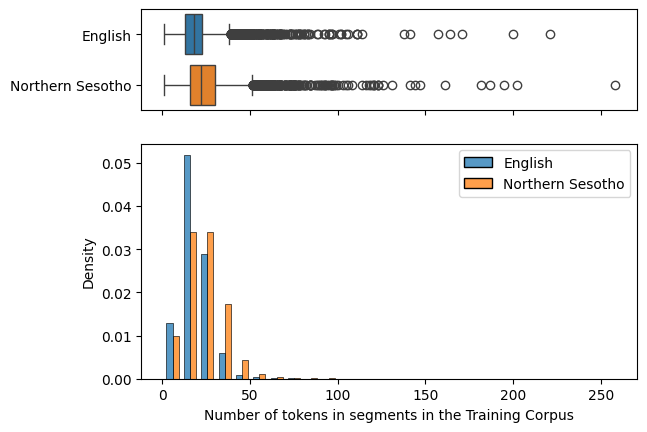

In [45]:
# visualise length of segments in parallel corpus
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len.iloc[:, [0,1]], orient="h", ax=ax_box)
sns.histplot(df_train_sent_len.iloc[:, [0,1]],
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments in the Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

In [46]:
# outliers on the source side of the training set
q1 = df_train_sent_len.iloc[:, 0].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 0].quantile(0.75)
iqr =  q3 - q1
lower_source_outliers = q1 - (3 * iqr)
upper_source_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the source side of training corpus: ({lower_source_outliers}, {upper_source_outliers})")

# outliers of the target side
q1 = df_train_sent_len.iloc[:, 1].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 1].quantile(0.75)
iqr =  q3 - q1
lower_target_outliers = q1 - (3 * iqr)
upper_target_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the target side of training corpus: ({lower_target_outliers}, {upper_target_outliers})")

The outliers upper and lower bounds for the source side of training corpus: (-17.0, 53.0)
The outliers upper and lower bounds for the target side of training corpus: (-26.0, 72.0)


In [47]:
data_table.DataTable(df_train[df_train_sent_len[source_name] > 60], include_index=True, num_rows_per_page=20)



,English,Northern Sesotho
67,A person who becomes liable for the payment of...,Motho yo a gapeletšegago go lefela motšhelo wa...
224,Having noted that the tardiness with which gov...,Ka ge re lemogile gore tšhomelo ya mmušo e tlo...
847,"A reconnaissance permission , prospecting righ...","Tumelelo ya dinyakišišo , tokelo ya diteko , t..."
1049,"For this , we will require a National War Room...","Mabapi le se , re tla hloka Ngwako wa Ntwa wa ..."
1457,Municipal public works only in respect of the ...,Mediro ya setšhaba ya mmasepala go ya ka dinya...
...,...,...
20516,Provided that this subsection shall also apply...,Ge fela karolwana ye le yona e tlo šoma godimo...
20685,"An international agreement of a technical , ad...",Kwano ya ditšhabatšhaba ya mohuta wa teknikale...
20720,Anyone holding office or deemed to hold office...,Mang le mang yo a lego maemong a Mopresidente ...
21010,For any enquiries please contact the relevant ...,Bakeng sa dinyakišiso tše dingwe le tše dingwe...


In [48]:
data_table.DataTable(df_train[df_train_sent_len[target_name] > 80], include_index=True, num_rows_per_page=20)

,English,Northern Sesotho
224,Having noted that the tardiness with which gov...,Ka ge re lemogile gore tšhomelo ya mmušo e tlo...
833,Parties registered in terms of national legisl...,Go tlošwa ga temana 16 gomme legatong lsa yona...
847,"A reconnaissance permission , prospecting righ...","Tumelelo ya dinyakišišo , tokelo ya diteko , t..."
1049,"For this , we will require a National War Room...","Mabapi le se , re tla hloka Ngwako wa Ntwa wa ..."
1261,Item 7 of Schedule II to the principal Act is ...,ka go engwa legatong la ntlha ya ka tlase ya k...
1470,Section 245 of the previous Constitution conti...,mme moetapele wa setšo wa setšhaba seo se late...
1722,Storage - Any person or body storing water for...,Polokelo - Motho o fe goba o fe goba setho seo...
2019,duce any mineral or petroleum or commence with...,Ga go motho yoo a ka nyakago diepšane goba a t...
2596,"I am confident that , under the leadership of ...",Ke a tshepa gore ka tlase ga Khansele ya Lefas...
2646,Amendment of section 46 of Act 28 of 2002Secti...,"Ge tokelo ya go nyaka diepšane , ya go epa , y..."


In [49]:
# outliers on the source side of the validation set
q1 = df_val_sent_len.iloc[:, 0].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 0].quantile(0.75)
iqr =  q3 - q1
lower_source_outliers = q1 - (3 * iqr)
upper_source_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the source side of the validation corpus: ({lower_source_outliers}, {upper_source_outliers})")

# outliers of the target side
q1 = df_val_sent_len.iloc[:, 1].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 1].quantile(0.75)
iqr =  q3 - q1
lower_target_outliers = q1 - (3 * iqr)
upper_target_outliers = q3 + (3 * iqr)
print(f"The outliers upper and lower bounds for the target side of the validation corpus: ({lower_target_outliers}, {upper_target_outliers})")

The outliers upper and lower bounds for the source side of the validation corpus: (-21.0, 56.0)
The outliers upper and lower bounds for the target side of the validation corpus: (-27.0, 71.0)


In [50]:
# dropping segment pairs in training corpus
source_max_length = 60
target_max_length = 80

source_min_length = 1
target_min_length = 1

drop_index = []

for i in range(len(df_train_sent_len)):
  if df_train_sent_len.iloc[i,0] < source_min_length:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,0] > source_max_length:
    drop_index.append(i)

  if df_train_sent_len.iloc[i,1] < target_min_length:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,1] > target_max_length:
    drop_index.append(i)

drop_index = list(set(drop_index))
df_train.drop(drop_index, axis=0, inplace=True)
df_train_sent_len.drop(drop_index, axis=0, inplace=True)

In [51]:
# resetting index in dataframes after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_train_sent_len.reset_index(drop=True, inplace=True)

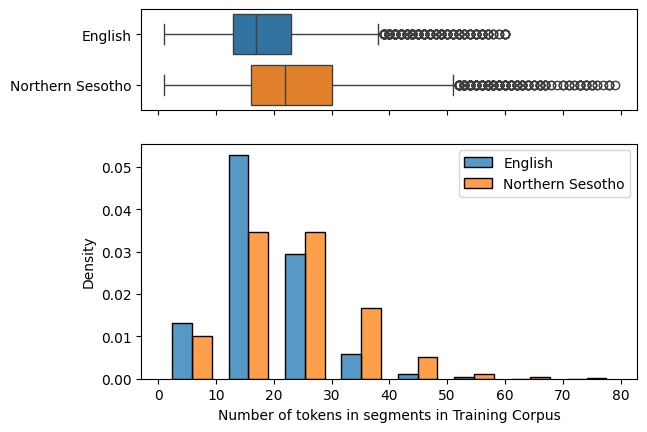

In [52]:
# visualise data!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len, orient="h", ax=ax_box)
sns.histplot(df_train_sent_len,
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments in Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

In [53]:
# dropping segment pairs in validation corpus
source_max_length = 60
target_max_length = 80

source_min_length = 1
target_min_length = 1

drop_index = []

for i in range(len(df_val_sent_len)):
  if df_val_sent_len.iloc[i,0] < source_min_length:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,0] > source_max_length:
    drop_index.append(i)

  if df_val_sent_len.iloc[i,1] < target_min_length:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,1] > target_max_length:
    drop_index.append(i)

drop_index = list(set(drop_index))
df_val.drop(drop_index, axis=0, inplace=True)
df_val_sent_len.drop(drop_index, axis=0, inplace=True)

In [54]:
# resetting index in dataframes after dropping segment pairs
df_val.reset_index(drop=True, inplace=True)
df_val_sent_len.reset_index(drop=True, inplace=True)

### Removing segment pairs with significant source to target ratio w.r.t length of segments in a pair

In [55]:
# add a column to dataframe: length of source segment/length of target segment
df_train_sent_len = df_train_sent_len.assign(ratio = df_train_sent_len[source_name]/df_train_sent_len[target_name])
print("Summary for Training Corpus:")
print(df_train_sent_len.describe())

df_val_sent_len = df_val_sent_len.assign(ratio = df_val_sent_len[source_name]/df_val_sent_len[target_name])
print("\nSummary for Validation Corpus:")
print(df_val_sent_len.describe())

Summary for Training Corpus:
            English  Northern Sesotho         ratio
count  21161.000000      21161.000000  21161.000000
mean      18.353480         23.166675      0.828699
std        8.086623         10.599428      0.273884
min        1.000000          1.000000      0.059701
25%       13.000000         16.000000      0.700000
50%       17.000000         22.000000      0.800000
75%       23.000000         30.000000      0.920000
max       60.000000         79.000000     11.000000

Summary for Validation Corpus:
           English  Northern Sesotho        ratio
count  6378.000000       6378.000000  6378.000000
mean     17.916902         22.585764     0.828215
std       8.345093         10.821485     0.255440
min       1.000000          1.000000     0.121212
25%      12.000000         15.000000     0.700000
50%      17.000000         22.000000     0.800000
75%      23.000000         29.000000     0.925926
max      60.000000         78.000000     6.600000


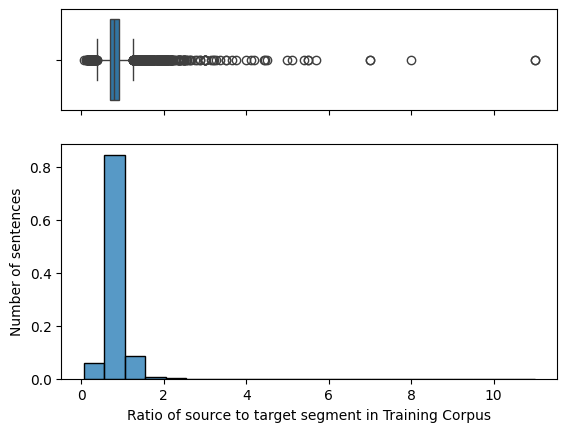

In [56]:
# visualising ratio of source to target segments pairs
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_train_sent_len.iloc[:, 2], orient="h", ax=ax_box)
sns.histplot(df_train_sent_len.iloc[:, 2],
             binwidth=0.5,
             stat='proportion',
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Ratio of source to target segment in Training Corpus")
ax_hist.set_ylabel("Number of sentences")

# display plot
plt.show()

In [57]:
# finding outlier segment pairs in the training corpus
q1 = df_train_sent_len.iloc[:, 2].quantile(0.25)
q3 = df_train_sent_len.iloc[:, 2].quantile(0.75)
iqr =  q3 - q1
lower_outliers = q1 - (1.5 * iqr)
upper_outliers = q3 + (1.5 * iqr)

print(f"The outliers upper and lower bounds of the training corpus: ({lower_outliers}, {upper_outliers})")

The outliers upper and lower bounds of the training corpus: (0.36999999999999983, 1.2500000000000002)


In [58]:
# finding outlier segment pairs in the validation corpus
q1 = df_val_sent_len.iloc[:, 2].quantile(0.25)
q3 = df_val_sent_len.iloc[:, 2].quantile(0.75)
iqr =  q3 - q1
lower_outliers = q1 - (1.5 * iqr)
upper_outliers = q3 + (1.5 * iqr)

print(f"The outliers upper and lower bounds of the validation corpus: ({lower_outliers}, {upper_outliers})")

The outliers upper and lower bounds of the validation corpus: (0.361111111111111, 1.2648148148148148)


In [59]:
# which segment pairs in the training corpus to drop?
max_ratio = 2
min_ratio = 3/10

drop_index = []
for i in range(len(df_train_sent_len)):
  if df_train_sent_len.iloc[i,2] < min_ratio:
    drop_index.append(i)
  if df_train_sent_len.iloc[i,2] > max_ratio:
    drop_index.append(i)

drop_index = list(set(drop_index))

In [60]:
# visualising segment pairs that have been dropped
data_table.DataTable(df_train.iloc[drop_index,:], include_index=True, num_rows_per_page=20)

,English,Northern Sesotho
16389,The potential role of a mineral marketing audi...,Ditlamorago tše dingwe gape e be e le gore tem...
7,or in fulfilment of an international obligation .,"Ke Mopresidente fela , bjalo ka hlogo ya khudu..."
13833,The Constitution mandates that it should be co...,Ye nngwe ya tše ke mafelelo a Ntwa ya Megopolo...
3088,The production and distribution of dry matter ...,"Ge a bolela le babegi ba ditaba , Holmes o bol..."
2065,Amendment of section 49 of Act 28 of 2002,Go ya ka karolo 48 ya Molao wa Bosetšhaba wa T...
...,...,...
11760,Signs affixed flat onto or painted on a parape...,Maswao a adilwe mo maboteng le mathuding .
3577,Corruption,Go utswa / tšeela ka kgang
2042,I say all this being aware of the fact that so...,Kwano ya go hlompha dikwano ka moka tša go nya...
14331,Submit the following to the local authority wh...,Fana ka tshedimošo ye e latelago .


In [61]:
# dropping segment pairs in training corpus
df_train.drop(drop_index, axis=0, inplace=True)
df_train_sent_len.drop(drop_index, axis=0, inplace=True)
print(f"The number of segment pairs left in the training corpus: {len(df_train)}")

# resetting index in dataframe after dropping segment pairs
df_train.reset_index(drop=True, inplace=True)
df_train_sent_len.reset_index(drop=True, inplace=True)

The number of segment pairs left in the training corpus: 20994


In [62]:
# dropping segment pairs in validation corpus
drop_index = []
for i in range(len(df_val_sent_len)):
  if df_val_sent_len.iloc[i,2] < min_ratio:
    drop_index.append(i)
  if df_val_sent_len.iloc[i,2] > max_ratio:
    drop_index.append(i)

drop_index = list(set(drop_index))

df_val.drop(drop_index, axis=0, inplace=True)
df_val_sent_len.drop(drop_index, axis=0, inplace=True)
print(f"The number of segment pairs left in the validation corpus: {len(df_val)}")

# resetting index in dataframe after dropping segment pairs
df_val.reset_index(drop=True, inplace=True)
df_val_sent_len.reset_index(drop=True, inplace=True)

The number of segment pairs left in the validation corpus: 6336


## Token Count

### Comparing source token count between training, validation and test sets:

In [63]:
# create a new dataframe: length of segment on each side of the parallel corpora
df_segment_len = pd.DataFrame({f"{source_name} in Train": df_train[source_name].str.split().apply(len),
                            f"{source_name} in Validation": df_val[source_name].str.split().apply(len),
                            f"{source_name} in Test": df_test[source_name].str.split().apply(len)})

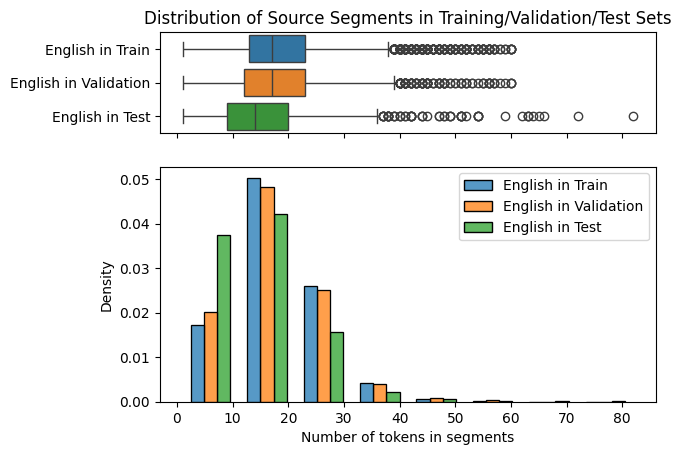

In [64]:
# visualise data!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot(df_segment_len, orient="h", ax=ax_box)
sns.histplot(df_segment_len,
             binwidth=10,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             legend=True,
             common_norm=False,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Number of tokens in segments")
ax_box.set_title("Distribution of Source Segments in Training/Validation/Test Sets")

# display plot
plt.show()

### Token count (incl. words, numbers and punctuation):

In [65]:
df_tokens_count = df_train.copy(deep=True)

# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count = defaultdict(int)
target_tokens_count = defaultdict(int)

# counting number of tokens
for segment in df_tokens_count[source_name]:
  for word in segment.split():
    source_tokens_count[word] += 1

for segment in df_tokens_count[target_name]:
  for word in segment.split():
    target_tokens_count[word] += 1

print(f"Number of unique tokens (incl. words, numbers and punctuation) on the {source_name} side is: {len(source_tokens_count)}.")
print(f"Number of tokens (incl. words, numbers and punctuation) on the {source_name} side is: {sum(source_tokens_count.values())}.")
print()
print(f"Number of unique tokens (incl. words, numbers and punctuation) on the {target_name} side is: {len(target_tokens_count)}.")
print(f"Number of tokens (incl. words, numbers and punctuation) on the {target_name} side is: {sum(target_tokens_count.values())}.")

Number of unique tokens (incl. words, numbers and punctuation) on the English side is: 28465.
Number of tokens (incl. words, numbers and punctuation) on the English side is: 385409.

Number of unique tokens (incl. words, numbers and punctuation) on the Northern Sesotho side is: 27565.
Number of tokens (incl. words, numbers and punctuation) on the Northern Sesotho side is: 487008.


### Token count (incl. words and numbers):

In [66]:
# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count2 = source_tokens_count.copy()
target_tokens_count2 = target_tokens_count.copy()

# counting number of tokens
for token in source_tokens_count:
  if token in punc:
    source_tokens_count2.pop(token)

for token in target_tokens_count:
  if token in punc:
    target_tokens_count2.pop(token)

print(f"Number of unique tokens (incl. words and numbers) on the {source_name} side is: {len(source_tokens_count2)}.")
print(f"Number of tokens (incl. words and numbers) on the {source_name} side is: {sum(source_tokens_count2.values())}.")
print()
print(f"Number of unique tokens (incl. words and numbers) on the {target_name} side is: {len(target_tokens_count2)}.")
print(f"Number of tokens (incl. words and numbers) on the {target_name} side is: {sum(target_tokens_count2.values())}.")

Number of unique tokens (incl. words and numbers) on the English side is: 28447.
Number of tokens (incl. words and numbers) on the English side is: 350981.

Number of unique tokens (incl. words and numbers) on the Northern Sesotho side is: 27542.
Number of tokens (incl. words and numbers) on the Northern Sesotho side is: 453430.


### Token count (i.e., just words):

In [67]:
# create new dataframes: length of words on each side of the parallel corpus
source_tokens_count3 = source_tokens_count2.copy()
target_tokens_count3 = target_tokens_count2.copy()

# counting number of tokens
for token in source_tokens_count2:
  if token.isdigit() == True:
    source_tokens_count3.pop(token)

for token in target_tokens_count2:
  if token.isdigit() == True:
    target_tokens_count3.pop(token)

print(f"Number of unique tokens (i.e. just words) on the {source_name} side is: {len(source_tokens_count3)}.")
print(f"Number of tokens (i.e. just words) on the {source_name} side is: {sum(source_tokens_count3.values())}.")
print()
print(f"Number of unique tokens (i.e. just words) on the {target_name} side is: {len(target_tokens_count3)}.")
print(f"Number of tokens (i.e. just words) on the {target_name} side is: {sum(target_tokens_count3.values())}.")

Number of unique tokens (i.e. just words) on the English side is: 28161.
Number of tokens (i.e. just words) on the English side is: 349003.

Number of unique tokens (i.e. just words) on the Northern Sesotho side is: 27261.
Number of tokens (i.e. just words) on the Northern Sesotho side is: 451478.


### Comparing length of words between source and target:

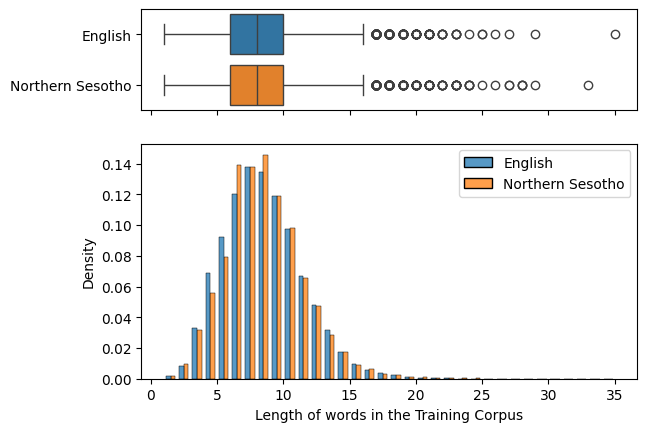

In [68]:
# create a new dataframe: length of segment on each side of the parallel corpora
source_word_len = pd.DataFrame({word: list(source_tokens_count3.keys())})
source_word_len = source_word_len.assign(source_name = source_word_len[word].str.len())
source_word_len = source_word_len.rename(columns={'source_name': source_name})
target_word_len = pd.DataFrame({word: list(target_tokens_count3.keys())})
target_word_len = target_word_len.assign(target_name = target_word_len[word].str.len())
target_word_len = target_word_len.rename(columns={'target_name': target_name})

# visualise!
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.3, .7)})
sns.boxplot([source_word_len.iloc[:, 1], target_word_len.iloc[:, 1]], orient="h", ax=ax_box)
sns.histplot([source_word_len.iloc[:, 1], target_word_len.iloc[:, 1]],
             binwidth=1,
             stat='density',
             multiple='dodge',
             shrink=0.7,
             common_norm=False,
             legend=True,
             ax=ax_hist)

# add labels to plots
ax_hist.set_xlabel("Length of words in the Training Corpus")
ax_hist.set_ylabel("Density")

# display plot
plt.show()

## Convert Datasets to Binary Files

For tokenization and model building...

In [69]:
with open(f'{main_path}/cleaned-data/train.{source_code}', 'w') as f:
  for segment in df_train[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/train.{target_code}', 'w') as f:
  for segment in df_train[target_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/val.{source_code}', 'w') as f:
  for segment in df_val[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/val.{target_code}', 'w') as f:
  for segment in df_val[target_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/test.{source_code}', 'w') as f:
  for segment in df_test[source_name]:
    f.write(segment + '\n')

with open(f'{main_path}/cleaned-data/test.{target_code}', 'w') as f:
  for segment in df_test[target_name]:
    f.write(segment + '\n')